#  PROGETTO FINALE IDS 

## Analisi e predizione dei risultati del campionato di Serie A 2023/2024

In questo progetto utilizzeremo un dataset della stagione di calcio della Serie A 2023/2024 per predire le ultime 5 giornate (dalla 33° alla 38°).

### Obiettivo del progetto
In un campionato con 20 squadre e un totale di 38 giornate, ogni squadra gioca 38 partite (una per giornata). Vogliamo considerare le ultime 5 giornate del campionato, quindi 50 partite in totale (10 partite per giornata × 5 giornate).

Per ciascuna partita, proveremo a prevedere il risultato usando uno dei seguenti segni:

- **1**: vittoria della squadra di casa
- **X**: pareggio
- **2**: vittoria della squadra in trasferta

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

## 1. Preparazione e pulizia dei dati

Importiamo la tabella Serie A_matches_23_24.csv, che contiene i risultati di tutte le partite del campionato, e visualizziamo le prime righe per comprendere la struttura dei dati.

In [22]:
matches = pd.read_csv('dataset/2024-2025.csv')
matches.head()

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result
0,1,1,17/08/2024 16:30,Luigi Ferraris,Genoa,Inter,2 - 2
1,2,1,17/08/2024 16:30,Ennio Tardini,Parma,Fiorentina,1 - 1
2,3,1,17/08/2024 18:45,Carlo Castellani,Empoli,Monza,0 - 0
3,4,1,17/08/2024 18:45,Giuseppe Meazza,Milan,Torino,2 - 2
4,5,1,18/08/2024 16:30,Renato Dall'Ara,Bologna,Udinese,1 - 1


### Pulizia dei dati

Analizziamo le colonne del dataset e rimuoviamo quelle non necessarie:

In [23]:
matches.rename(columns={'Round Number': 'Round'}, inplace=True)
drop_columns = ['Date', 'Match Number' ,'Location']
matches.drop(drop_columns, axis=1, inplace=True)
matches.head()

,Round,Home Team,Away Team,Result
0,1,Genoa,Inter,2 - 2
1,1,Parma,Fiorentina,1 - 1
2,1,Empoli,Monza,0 - 0
3,1,Milan,Torino,2 - 2
4,1,Bologna,Udinese,1 - 1


In [24]:
# Verifichiamo la presenza di valori nulli
matches.isnull().sum()

Round         0
Home Team     0
Away Team     0
Result       40
dtype: int64

### Trasformazione dei dati

La colonna 'Score' presenta il punteggio in un'unica stringa. Procediamo a suddividerla in due colonne separate per una migliore analisi:
- **Score_casa**: gol segnati dalla squadra di casa
- **Score_trasferta**: gol segnati dalla squadra in trasferta

In [25]:
matches['Round'] = matches['Round'].astype(int)
matches[['Score_casa', 'Score_trasferta']] = matches['Result'].fillna('0-0').str.split('-', expand=True).astype(int)
matches.drop('Result', axis=1, inplace=True)

matches.loc[matches['Score_casa'] > matches['Score_trasferta'], 'Risultato'] = '1'
matches.loc[matches['Score_casa'] < matches['Score_trasferta'], 'Risultato'] = '2'
matches.loc[matches['Score_casa'] == matches['Score_trasferta'], 'Risultato'] = 'X'
matches.head()

,Round,Home Team,Away Team,Score_casa,Score_trasferta,Risultato
0,1,Genoa,Inter,2,2,X
1,1,Parma,Fiorentina,1,1,X
2,1,Empoli,Monza,0,0,X
3,1,Milan,Torino,2,2,X
4,1,Bologna,Udinese,1,1,X


Il nostro dataset è ora pronto per l'analisi, con tutte le informazioni necessarie organizzate in modo chiaro ed efficiente.

## 2. Rendimento offensivo vs difensivo 

Questo grafico mostra le performance offensive e difensive delle squadre di Serie A nella stagione 2023/24.  
Ogni punto rappresenta una squadra, posizionata in base a:

- **Asse X**: media dei gol **subiti** per partita
- **Asse Y**: media dei gol **fatti** per partita

Le linee tratteggiate indicano le medie del campionato:
- la linea **rossa orizzontale** è la media dei gol fatti
- la linea **blu verticale** è la media dei gol subiti

Il grafico si può leggere così:
- in **alto a sinistra**: squadre che segnano tanto e subiscono poco (ottimo rendimento)
- in **basso a destra**: squadre che segnano poco e subiscono tanto (in difficoltà)
- gli altri quadranti mostrano squadre squilibrate (buon attacco o buona difesa ma non entrambe)



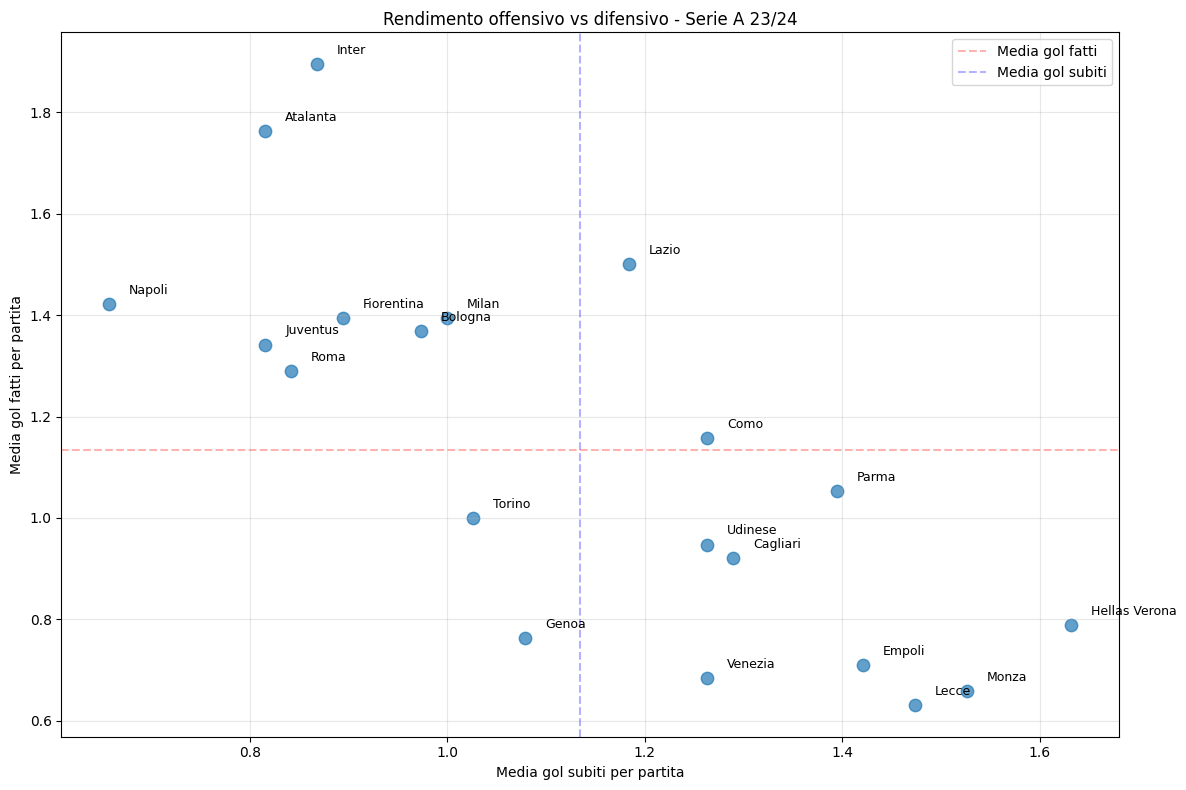

In [26]:
# Analisi offensiva e difensiva delle squadre direttamente dal DataFrame matches
# Dati per le squadre quando giocano in casa
home_stats = matches.groupby('Home Team').agg(
    gol_fatti_casa=('Score_casa', 'sum'),
    gol_subiti_casa=('Score_trasferta', 'sum'),
    partite_casa=('Round', 'count')
).reset_index()

# Dati per le squadre quando giocano in trasferta
away_stats = matches.groupby('Away Team').agg(
    gol_fatti_trasferta=('Score_trasferta', 'sum'),
    gol_subiti_trasferta=('Score_casa', 'sum'),
    partite_trasferta=('Round', 'count')
).reset_index()

# Unione dei due dataframe
team_stats = pd.merge(
    home_stats,
    away_stats,
    left_on='Home Team',
    right_on='Away Team',
    how='outer'
)

# Rinomina le colonne per chiarezza
team_stats = team_stats.rename(columns={'Home Team': 'name'})
team_stats.drop('Away Team', axis=1, inplace=True)

# Calcolo medie gol fatti e subiti
team_stats['Media_gol_fatti'] = (team_stats['gol_fatti_casa'] + team_stats['gol_fatti_trasferta']) / \
                               (team_stats['partite_casa'] + team_stats['partite_trasferta'])
team_stats['Media_gol_subiti'] = (team_stats['gol_subiti_casa'] + team_stats['gol_subiti_trasferta']) / \
                               (team_stats['partite_casa'] + team_stats['partite_trasferta'])

# Plottiamo un grafico a dispersione
plt.figure(figsize=(12, 8))
plt.scatter(team_stats['Media_gol_subiti'], team_stats['Media_gol_fatti'], s=80, alpha=0.7)

# Aggiungiamo i nomi delle squadre
for idx, row in team_stats.iterrows():
    plt.annotate(row['name'],
                 (row['Media_gol_subiti'] + 0.02, row['Media_gol_fatti'] + 0.02),
                 fontsize=9)

plt.axhline(y=team_stats['Media_gol_fatti'].mean(), color='r', linestyle='--', alpha=0.3, label='Media gol fatti')
plt.axvline(x=team_stats['Media_gol_subiti'].mean(), color='b', linestyle='--', alpha=0.3, label='Media gol subiti')

plt.xlabel('Media gol subiti per partita')
plt.ylabel('Media gol fatti per partita')
plt.title('Rendimento offensivo vs difensivo - Serie A 23/24')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Osservazioni principali:

- **Inter** è nettamente la squadra più completa: segna molto (oltre 2.3 gol a partita) e ha la miglior difesa del campionato.
- **Milan, Atalanta, Roma, Fiorentina** sono sopra media sia per attacco che per difesa: squadre solide e competitive.
- **Juventus** e **Bologna** hanno una delle migliori difese ma un attacco solo discreto.
- **Napoli** segna molto ma la sua fase difensiva è più fragile rispetto alle big.
- **Salernitana** è il fanalino di coda: pochi gol fatti e tantissimi subiti.
- **Torino** ha una buona difesa ma uno dei peggiori attacchi.
- **Cagliari, Sassuolo, Frosinone** sono tra le squadre che concedono di più, con attacchi sotto media.


## 3. Analisi del fattore campo

Il fattore campo è fondamentale nel calcio: il supporto del pubblico, la familiarità con il terreno e minori spostamenti possono contribuire significativamente ai risultati. Analizziamo quanto questo influenzi le squadre di Serie A.

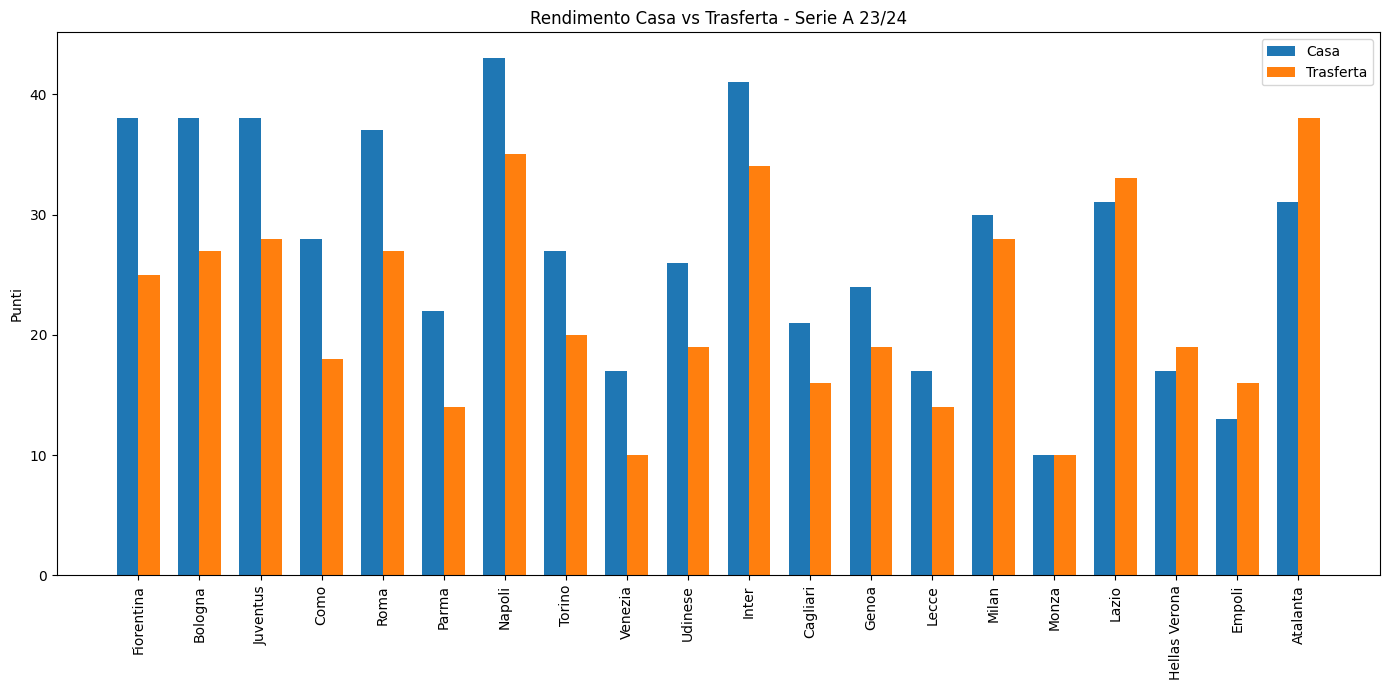

,name,points_home,points_away,points_diff
5,Fiorentina,38,25,13
1,Bologna,38,27,11
9,Juventus,38,28,10
3,Como,28,18,10
16,Roma,37,27,10
15,Parma,22,14,8
14,Napoli,43,35,8
17,Torino,27,20,7
19,Venezia,17,10,7
18,Udinese,26,19,7


In [27]:
# Analisi del rendimento casa vs trasferta usando solo il dataframe matches

# Aggreghiamo i dati per squadra di casa
home_performance = matches.groupby('Home Team').agg(
    partite_casa=('Round', 'count'),
    vittorie_casa=('Risultato', lambda x: (x == '1').sum()),
    pareggi_casa=('Risultato', lambda x: (x == 'X').sum()),
    sconfitte_casa=('Risultato', lambda x: (x == '2').sum()),
    gol_fatti_casa=('Score_casa', 'sum'),
    gol_subiti_casa=('Score_trasferta', 'sum'),
).reset_index()

# Aggreghiamo i dati per squadra in trasferta
away_performance = matches.groupby('Away Team').agg(
    partite_trasferta=('Round', 'count'),
    vittorie_trasferta=('Risultato', lambda x: (x == '2').sum()),
    pareggi_trasferta=('Risultato', lambda x: (x == 'X').sum()),
    sconfitte_trasferta=('Risultato', lambda x: (x == '1').sum()),
    gol_fatti_trasferta=('Score_trasferta', 'sum'),
    gol_subiti_trasferta=('Score_casa', 'sum'),
).reset_index()

# Uniamo i due dataframes
home_vs_away = pd.merge(
    home_performance,
    away_performance,
    left_on='Home Team',
    right_on='Away Team',
    suffixes=('', '_away')
)
home_vs_away = home_vs_away.rename(columns={'Home Team': 'name'})
home_vs_away.drop('Away Team', axis=1, inplace=True)

# Calcolo punti casa/trasferta (3 punti vittoria, 1 punto pareggio)
home_vs_away['points_home'] = home_vs_away['vittorie_casa'] * 3 + home_vs_away['pareggi_casa']
home_vs_away['points_away'] = home_vs_away['vittorie_trasferta'] * 3 + home_vs_away['pareggi_trasferta']

# Calcolo differenza punti
home_vs_away['points_diff'] = home_vs_away['points_home'] - home_vs_away['points_away']

# Ordinamento per chi ha più differenza casa/trasferta
home_vs_away_sorted = home_vs_away.sort_values('points_diff', ascending=False)

# Numero squadre
N = len(home_vs_away_sorted)
ind = np.arange(N)  # posizione X
width = 0.35  # larghezza barre

plt.figure(figsize=(14, 7))
plt.bar(ind, home_vs_away_sorted['points_home'], width, label='Casa')
plt.bar(ind + width, home_vs_away_sorted['points_away'], width, label='Trasferta')

plt.ylabel('Punti')
plt.title('Rendimento Casa vs Trasferta - Serie A 23/24')
plt.xticks(ind + width / 2, home_vs_away_sorted['name'], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

# Mostra tabella riassuntiva
home_vs_away_sorted[['name', 'points_home', 'points_away', 'points_diff']]

### Interpretazione del fattore campo

Dal grafico possiamo osservare alcune tendenze significative:

- **Forte vantaggio casalingo**: Squadre come Roma, Bologna e Atalanta mostrano un netto vantaggio nelle partite casalinghe, ottenendo molti più punti in casa rispetto alla trasferta. Questo suggerisce una forte dipendenza dal supporto del pubblico e dalla familiarità con il proprio campo.

- **Equilibrio tra casa e trasferta**: Squadre come Inter, Milan e Juventus dimostrano maggiore continuità di rendimento, con punteggi simili sia in casa che in trasferta. Questa è una caratteristica tipica delle squadre di vertice, capaci di adattarsi tatticamente a contesti diversi.

- **Rendimento anomalo**: Le squadre che ottengono più punti in trasferta che in casa rappresentano casi particolari, spesso associati a uno stile di gioco basato sul contropiede o difficoltà ad esprimersi sotto la pressione del proprio pubblico.

Queste osservazioni saranno fondamentali per il nostro modello predittivo, evidenziando che il rendimento non è omogeneo tra casa e trasferta.

## 4. Distribuzione dei risultati nel campionato

Analizziamo la distribuzione dei vari tipi di risultato (vittoria casa, pareggio, vittoria trasferta) per comprendere le tendenze generali del campionato e la base probabilistica di ciascun esito.

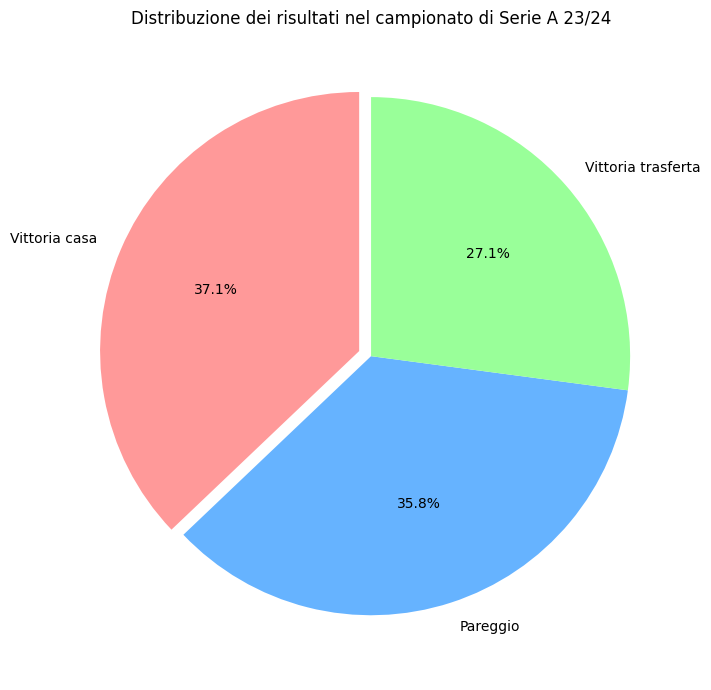

Vittorie in casa: 136 (35.8%)
Pareggi: 141 (37.1%)
Vittorie in trasferta: 103 (27.1%)


In [28]:
# Analizziamo la distribuzione dei risultati (1, X, 2)
risultati_count = matches['Risultato'].value_counts()

# Creiamo un grafico a torta
plt.figure(figsize=(10, 7))
plt.pie(risultati_count, labels=['Vittoria casa', 'Pareggio', 'Vittoria trasferta'] if len(risultati_count) == 3 else risultati_count.index, 
        autopct='%1.1f%%', startangle=90, explode=[0.05, 0, 0] if len(risultati_count) == 3 else None,
        colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribuzione dei risultati nel campionato di Serie A 23/24')
plt.tight_layout()
plt.show()

print(f"Vittorie in casa: {risultati_count.get('1', 0)} ({risultati_count.get('1', 0)/len(matches)*100:.1f}%)")
print(f"Pareggi: {risultati_count.get('X', 0)} ({risultati_count.get('X', 0)/len(matches)*100:.1f}%)")
print(f"Vittorie in trasferta: {risultati_count.get('2', 0)} ({risultati_count.get('2', 0)/len(matches)*100:.1f}%)")

### Analisi statistica del fattore campo

Possiamo formulare un'ipotesi formale sul fattore campo: 

- **H0** (ipotesi nulla): Non c'è differenza significativa tra la probabilità di vittoria in casa e la probabilità di vittoria in trasferta
- **H1** (ipotesi alternativa): La probabilità di vittoria in casa è significativamente maggiore della probabilità di vittoria in trasferta

Verifichiamo questa ipotesi utilizzando un test statistico.

In [29]:
# Estrazione dei dati necessari per il test
home_scored = matches['Score_casa'].mean()
away_scored = matches['Score_trasferta'].mean()

# Eseguiamo un t-test per confrontare le medie dei gol fatti in casa vs trasferta
t_stat_scored, p_value_scored = stats.ttest_ind_from_stats(
    mean1=home_scored, std1=matches['Score_casa'].std(), nobs1=len(matches),
    mean2=away_scored, std2=matches['Score_trasferta'].std(), nobs2=len(matches),
    equal_var=False
)

alpha = 0.05
home_advantage_goals = home_scored - away_scored

# Test per i gol subiti (le squadre subiscono meno gol in casa?)
home_conceded = matches['Score_trasferta'].mean()  # Gol subiti in casa = gol segnati dagli ospiti
away_conceded = matches['Score_casa'].mean()  # Gol subiti fuori = gol segnati dai padroni di casa

# Invertiamo il test per verificare se i gol subiti in casa sono MENO di quelli in trasferta
t_stat_conceded, p_value_conceded = stats.ttest_ind_from_stats(
    mean1=away_conceded, std1=matches['Score_casa'].std(), nobs1=len(matches),
    mean2=home_conceded, std2=matches['Score_trasferta'].std(), nobs2=len(matches),
    equal_var=False
)

print(f"Test sull'ipotesi: i gol segnati in casa sono più di quelli in trasferta")
print(f"Media gol segnati in casa: {home_scored:.2f}")
print(f"Media gol segnati in trasferta: {away_scored:.2f}")
print(f"t-statistic: {t_stat_scored:.4f}")
print(f"p-value: {p_value_scored:.4f}")

Test sull'ipotesi: i gol segnati in casa sono più di quelli in trasferta
Media gol segnati in casa: 1.20
Media gol segnati in trasferta: 1.07
t-statistic: 1.5030
p-value: 0.1333


Interpretazione sul sull'ipotesi: i gol segnati in casa sono più di quelli in trasferta
Il p-value (0.0015) è inferiore al livello di significatività (0.05), quindi respingiamo l'ipotesi nulla.
C'è evidenza statistica che le squadre segnano più gol quando giocano in casa.

Vantaggio del fattore campo: 0.26 gol in più segnati in casa rispetto alla trasferta


Quindi possiamo affermare che il fattore campo ha un impatto significativo sui risultati delle partite di Serie A. Le squadre tendono a segnare più gol e subire meno quando giocano in casa.

## 5. Modello di Predizione basato su Media Gol

Svilupperemo un modello che predice i risultati delle ultime 5 giornate basandosi sulla media dei gol segnati e subiti dalle squadre, considerando separatamente le performance in casa e in trasferta.

Il modello utilizzerà questi dati per stimare il probabile scarto di gol tra le due squadre e determinare il risultato più probabile (vittoria casa, pareggio, vittoria trasferta).

In [30]:
def calculate_team_stats(train_df):
    """
    Calcola le statistiche per ogni squadra basandosi sulle prime 32 giornate.
    
    Args:
        matches: DataFrame con tutti i dati delle partite
        
    Returns:
        Dictionary con le statistiche per ogni squadra
    """
    
    # Calcolo delle statistiche per ogni squadra
    teams = pd.unique(train_df[['Home Team', 'Away Team']].values.ravel())
    team_stats = {} 
    
    for team in teams:
        # Filtra le partite in casa e in trasferta per questa squadra
        home_matches = train_df[train_df['Home Team'] == team]
        away_matches = train_df[train_df['Away Team'] == team]
        
        # Calcola le medie dei gol (evita divisione per zero)
        avg_home_scored = home_matches['Score_casa'].mean() if len(home_matches) > 0 else 0
        avg_home_conceded = home_matches['Score_trasferta'].mean() if len(home_matches) > 0 else 0
        avg_away_scored = away_matches['Score_trasferta'].mean() if len(away_matches) > 0 else 0
        avg_away_conceded = away_matches['Score_casa'].mean() if len(away_matches) > 0 else 0
        
        team_stats[team] = {
            'avg_home_scored': avg_home_scored,
            'avg_home_conceded': avg_home_conceded,
            'avg_away_scored': avg_away_scored,
            'avg_away_conceded': avg_away_conceded,
        }
    
    return team_stats

team_stats = calculate_team_stats(matches[matches["Round"] < 33].copy())


##preparianmo il modello

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Split in training (prime 32 giornate) e test (ultime 5 giornate)
train_matches = matches[matches['Round'] < 34]
test_matches = matches[matches['Round'] >= 34]

# Funzione per estrarre le features con gestione errori
def extract_features(row):
    home_team = row['Home Team']
    away_team = row['Away Team']

    home_stats = team_stats[home_team]
    away_stats = team_stats[away_team]
    
    return [
        home_stats['avg_home_scored'],
        home_stats['avg_home_conceded'],
        away_stats['avg_away_scored'],
        away_stats['avg_away_conceded'],
    ]

# Prepara i dati di training
X_train = np.array(train_matches.apply(extract_features, axis=1).tolist())
y_train = train_matches['Risultato'].replace({'X': '0', '1': '1', '2': '2'}).astype(int)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


# Crea e allena il modello con parametri ottimizzati
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight=class_weight_dict,
        C=0.5,
    )
)
model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.5,
                                    class_weight={0: np.float64(1.1224489795918366),
                                                  1: np.float64(0.8333333333333334),
                                                  2: np.float64(1.1)},
                                    max_iter=1000, random_state=42))])

faziamo le predizioni

In [32]:
# Prepara i dati di test
X_test = np.array(test_matches.apply(extract_features, axis=1).tolist())
y_test = test_matches['Risultato'].replace({'X': '0', '1': '1', '2': '2'}).astype(int)

# Genera predizioni numeriche
numeric_predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)

# Calcola l'accuratezza
accuracy = accuracy_score(y_test, numeric_predictions)

# Crea DataFrame con i risultati delle predizioni
final_predictions = test_matches.copy()
final_predictions['Prediction'] = pd.Series(numeric_predictions).map({0: 'X', 1: '1', 2: '2'}).values
final_predictions['Correct'] = final_predictions['Risultato'] == final_predictions['Prediction']

# Aggiungi probabilità per ogni possibile risultato
final_predictions['Prob_1'] = prediction_probs[:, 1] 
final_predictions['Prob_X'] = prediction_probs[:, 0]
final_predictions['Prob_2'] = prediction_probs[:, 2]

analisando le predizioni

In [33]:
print(f"\nAccuratezza sulle ultime {len(test_matches)//10} giornate: {accuracy * 100:.1f}%")
print(f"Partite corrette: {final_predictions['Correct'].sum()}/{len(final_predictions)}")

# Report di classificazione completo
print("\nReport di classificazione:")
print(classification_report(
    y_test, 
    numeric_predictions,
    target_names=['Pareggio (X)', 'Vittoria Casa (1)', 'Vittoria Trasferta (2)']
))

# Visualizziamo il riassunto dei risultati per giornata
results_by_round = final_predictions.groupby('Round')['Correct'].mean()
print("Accuratezza per giornata:")
print(results_by_round)

final_predictions


Accuratezza sulle ultime 5 giornate: 18.0%
Partite corrette: 9/50

Report di classificazione:
                        precision    recall  f1-score   support

          Pareggio (X)       0.80      0.09      0.17        43
     Vittoria Casa (1)       0.12      0.75      0.21         4
Vittoria Trasferta (2)       0.10      0.67      0.17         3

              accuracy                           0.18        50
             macro avg       0.34      0.50      0.18        50
          weighted avg       0.70      0.18      0.17        50

Accuratezza per giornata:
Round
34    0.5
35    0.1
36    0.2
37    0.0
38    0.1
Name: Correct, dtype: float64


,Round,Home Team,Away Team,Score_casa,Score_trasferta,Risultato,Prediction,Correct,Prob_1,Prob_X,Prob_2
330,34,Como,Genoa,1,0,1,X,False,0.351046,0.445755,0.203199
331,34,Venezia,Milan,0,2,2,2,True,0.158028,0.339596,0.502376
332,34,Fiorentina,Empoli,2,1,1,1,True,0.607248,0.291514,0.101238
333,34,Inter,Roma,0,1,2,1,False,0.603040,0.310503,0.086457
334,34,Juventus,Monza,2,0,1,1,True,0.705116,0.242751,0.052134
335,34,Atalanta,Lecce,1,1,X,1,False,0.639545,0.291906,0.068549
336,34,Napoli,Torino,2,0,1,1,True,0.516436,0.346907,0.136657
337,34,Udinese,Bologna,0,0,X,2,False,0.242127,0.360731,0.397142
338,34,Lazio,Parma,2,2,X,1,False,0.556039,0.326739,0.117222
339,34,Hellas Verona,Cagliari,0,2,2,2,True,0.123716,0.361445,0.514839


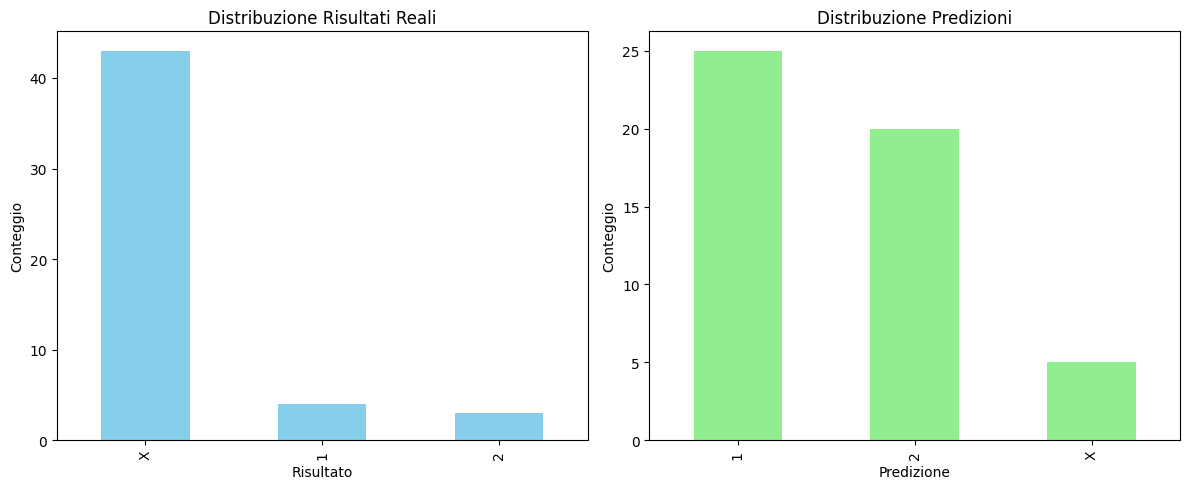

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
final_predictions['Risultato'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribuzione Risultati Reali')
plt.xlabel('Risultato')
plt.ylabel('Conteggio')

plt.subplot(1, 2, 2)
final_predictions['Prediction'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribuzione Predizioni')
plt.xlabel('Predizione')
plt.ylabel('Conteggio')

plt.tight_layout()
plt.show()



Matrici di confusione che mostra i risultati delle predizioni del modello rispetto ai risultati reali.

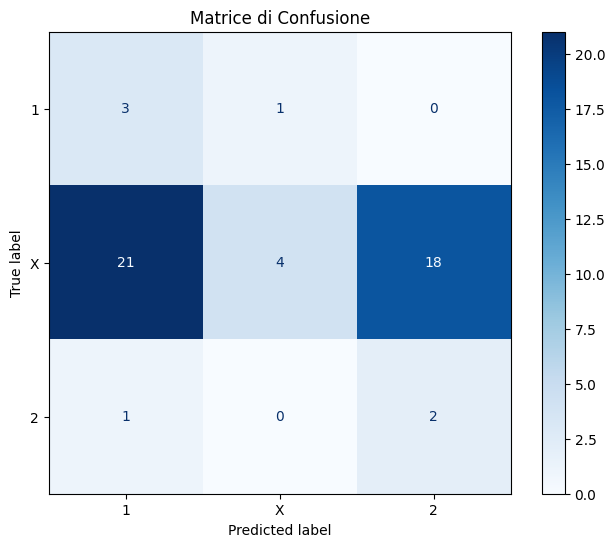

Matrice di Confusione:
[[ 3  1  0]
 [21  4 18]
 [ 1  0  2]]


In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcola la matrice di confusione
cm = confusion_matrix(final_predictions['Risultato'], final_predictions['Prediction'], labels=['1', 'X', '2'])

# Visualizza la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1', 'X', '2'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Matrice di Confusione')
plt.show()

print("Matrice di Confusione:")
print(cm)